# SoRAIM winter school - Speaker Extraction Workshop 
#### Hosted by Bar Ilan University (BIU)
prior knowledge: 
- Minor understanding of signal processing 
- Python


## 1. Intruduction (10 min)
<img src="media/ros4hri_ids.png" alt="h" width="700"/>


### Speech processing in HRI

In the SPRING project the patients and ARI are having a verbal dialogue. therefore the ability to understand the patient is key.
When failing to understand the patient, ARI could response poorly regarding the expectance of ARI or just respond in a completely wrong matter.
Scene the patient's speech might be overlapped with another human's voice (doctors,accompanying person,background speech etc.) we need to encounter and somehow get the wanted speech only.


There are two main ways of doing such task:
 1. "Blind" source separation - splits the overlapping speech to two channel (one for each speaker) with no prior data about the speakers.
 2. Speaker extraction - extract the wanted speaker from the overlapping speech by a reference audio signal of the wanted speaker.

Today we will focus on speaker extraction.

# <span style="color:red"> **example audio and ASR ** </span>


  




In [ ]:
! pip3 install requests ffmpeg-python
! pip3 install pip install "deepgram-sdk>=3.*,<4.0"
! pip3 install -r requirements.txt

In [1]:
# ASR
from deepgram import DeepgramClient, PrerecordedOptions
# go here and get an API key https://console.deepgram.com/signup
# The API key we created in step 3
DEEPGRAM_API_KEY = '9025aaf8281bd33ea44bc02d093247c2949d0b00'

# Hosted sample file
file_path_out = '/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/outputs/y_ckpt.wav'
file_mix='/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/mix.wav'
deepgram = DeepgramClient(DEEPGRAM_API_KEY)

def transcribe_wav(wav_path):
    with open(wav_path, 'rb') as buffer_data:
        payload = { 'buffer': buffer_data }

        options = PrerecordedOptions(
            smart_format=True, model="base", language="en-US"
        )
        response = deepgram.listen.prerecorded.v('1').transcribe_file(payload, options)
        trns = response.results.channels[0].alternatives[0].transcript
    return trns


## The tasks for today's workshop:
- [ ] Basics speaker extraction.
- [ ] Audio recording and feature extraction of audio data.
- [ ] Extracting your own voice from a mixture of two voices.
- [ ] Evaluating your results.

## 2. Basics of Speaker Extraction (20 minutes)

#### Target speech/speaker extraction (TSE) isolates the speech signal of a target speaker from a mixture of several speakers, with or without noises and  reverberations, using clues that identify the speaker in the mixture. Such clues might be a spatial clue indicating the direction of the target speaker, a video of the speaker’s lips, and a prerecorded enrollment utterance from which the speaker’s voice characteristics can be derived. 
<img src="media/delcroix01-3240008-large.gif" alt="extraction_clues" width="700">

- **Paragraph and image:** K. Zmolikova, M. Delcroix, T. Ochiai, K. Kinoshita, J. Cernocký, and D. Yu, ‘‘Neural target speech extraction: An overview,’’ IEEE Signal Process. Mag., vol. 0,  o. 3, pp. 8–29, May 2023 
  

#### In our approach, we propose a Siamese-Unet architecture that uses both representations. The Siamese encoders are applied in the frequency domain to infer the embedding of the noisy and reference spectra, respectively. The concatenated representations are then fed into the decoder to estimate the real and imaginary  components of the desired speaker, which are then inverse-transformed to the time-domain.

- A. Eisenberg, S. Gannot and S. E. Chazan, "Single microphone speaker extraction using unified time-frequency Siamese-Unet," 2022 30th European Signal Processing Conference (EUSIPCO), Belgrade, Serbia, 2022, pp. 762-766, doi: 10.23919/EUSIPCO55093.2022.9909545. 

## Introduction to the process of recording speech samples on laptops:
#### The audio samples in this section is from the Librispeech dataset from OpenSLR: https://www.openslr.org/11/
Audio is represented as a list of samples that correspond to the sound and time axis. 
Normalizing audio signal can be done in several ways, we will normalize in this method: 
$$
X_{norm} = \frac{0.9\cdot X }{max(abs(X))}\
$$
for example:

In [2]:
import soundfile as sf
import torch
import numpy as np

samples,sr = sf.read('audio_samples/males/28233/5105-28233-0006.wav')
print(samples[20:])
print(f'samplerate={sr}')

# TODO: implement the following functions
# hint when mixing two audio signals you add both signals and then normalize, make sure both signals has same length before summation!
 
def norm(samples):
    return 0.9*samples/max(abs(samples))

def mix(wav1,wav2,sir=0): #mixes two audio signals with sir
    #check lengths
    max_len = max(wav1.shape[-1],wav2.shape[-1])

    if torch.is_tensor(wav1) and torch.is_tensor(wav2):
        wav1 = norm(torch.cat((wav1.squeeze(),torch.zeros(max_len-wav1.shape[-1]))))
        wav2 = norm(torch.cat((wav2.squeeze(),torch.zeros(max_len-wav2.shape[-1]))))
        G =torch.sqrt(10 ** (-sir / 10) * torch.std(wav1) ** 2 / torch.std(wav2) ** 2)

    #np
    elif isinstance(wav1,(np.ndarray,np.generic)) and isinstance(wav2,(np.ndarray,np.generic)):
        wav1 = norm(np.concatenate((wav1,np.zeros(max_len-wav1.shape[-1]))))
        wav2 = norm(np.concatenate((wav2,np.zeros(max_len-wav2.shape[-1]))))
        G =np.sqrt(10 ** (-sir / 10) * np.std(wav1) ** 2 / np.std(wav2) ** 2)

    wav1 += G*wav2
    return norm(wav1).squeeze()

# ref1 = '/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/ref1.wav'
# ref2 = '/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/ref2.wav'

# ref1_vec,sr1 =sf.read(ref1) 
# ref2_vec,sr2 =sf.read(ref2) 
# m = mix(ref1_vec,ref2_vec)

[-0.00408936 -0.00186157 -0.00650024 ... -0.00250244 -0.00253296
 -0.00436401]
samplerate=16000


The variable **wav** represent the audio samples and the variable **sr** represents the sampling rate of the audio.

The sampling rate corresponds to the number of samples this file has in one second.

The sampling rate is important for processing and playback as well, playing the same file with a wrong sampling rate will result in distortion of the original audio.


# <span style="color:red"> For the next parts audio will be played on your PC, please keep the volume down or use headphones </span>

In [3]:
import IPython.display as ipd
import torch
print('Audio with correct sample rate')
def display_audio(samples,sr):
    if torch.is_tensor(samples):
        samples= samples.detach().numpy()
    ipd.display(ipd.Audio(samples,rate=sr))
display_audio(samples,sr)

Audio with correct sample rate


### Recording audio using Audacity:

1. open Audacity
2. choose 1 input channel (mono) (A)
3. click record (B)
   
<img src="media/audacity_1.png" width="700" >

4. then export the audio using: file -> export -> export as WAV
5. save .wav file and copy the file to your working directory of this notebook.
6. load file using soundfile 


## 3. Hands-on Session #1 : Signals and Spectograms (15 minutes)
### 3.a. Recording Speech Samples
record your self saying the following phrase:
- Hello from Grenoble! Today I learned about audio processing and speech extraction, Let's see if my voice could be extracted.

Export the audio to a .wav file and then record your self introducing yourself - should be a few second long.
Export the second .wav file.




In [4]:
#1. Load both files to two variables and play the files one after the other.
#2. play one of the files with sr != sr, how it sounds?
########## YOUR CODE HERE #######################

### 3.b. Hands-on Session: STFT domain

Now that you are familiar with digital audio, lets talk about spectrograms.

The sampled audio as a discrete-time signal that can be represented and processed in the time domain and in the frequency domain. 

Because the speech is a signal with large time variation (non-stationary signal), it is mandatory to use the STFT rather than simple fourier transform.

The STFT of the audio signal will give us the DFT (complex value) for each time frame, and by taking the absolute value of the STFT we get the spectrogram of the audio.

The spectrogram is used as an input feature to many deep learning algorithms. This way, the audio data can be thought of as an image. Among other processing methods, we can also adopt image processing techniques to analyze the audio signal and process it.


In [5]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def plot_spectrogram(samples,sr,nfft=512):
    samples = samples.squeeze()
    if not torch.is_tensor(samples):
        samples = torch.tensor(samples)
    samples_stft = torch.stft(samples,
                        n_fft=nfft,
                        hop_length=nfft//4,
                        win_length=nfft,
                        window=torch.hamming_window(nfft),
                        center=True,
                        pad_mode='reflect',
                        normalized=False,
                        onesided=None,
                        return_complex=True)
    spec = torch.abs(samples_stft)
    plt.figure(figsize = (10,10))
    plt.xlabel('Time')
    plt.ylabel('Frequency [Hz]')
    plt.yticks(np.arange(0,(nfft//2)+1 ,16),(np.arange(0,(nfft//2)+1 ,16)*(sr/(2*nfft//2))).astype(np.int16))
    ax = plt.gca()
    spec_plot =ax.imshow(20*torch.log10(spec),origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(spec_plot,cax=cax)
    cbar.set_label('Energy (dB)')
    plt.tight_layout()
    ax.set_title('Spectogram of the audio data in dB')
    plt.show()

# s,sr = sf.read('/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/ref1.wav')
# plot_spectrogram(s,sr)

In [5]:
#use this function to plot your Speech spectrogram
# play with the parameters: nfft, hop and win_length  - what is the efect on the spectrogram?
#### YOUR CODE HERE #######

# 4. Extraction model
The model arcitecture:

<img src="media/extraction_model.png" width="700">

Our model works with audio sampled at 8000 Hz, it will automaticly resample the audio will also return the extraacted audio in 8000 Hz.
When playing the extracted audio make sure to set SR=8000 !

TDL:
- [] load two audio files with **torchaudio** (HINT 1), one to be extracted and another one as interference (could be another workshop memeber or one from samples folder)
- [] Mix two files (make sure to have two diffrent speakers)
- [] Load a refrence file with torchaudio as well
- [] Start a speaker extration class instance (HINT 2)
- [] Use the extract_vec method to extract your voice.


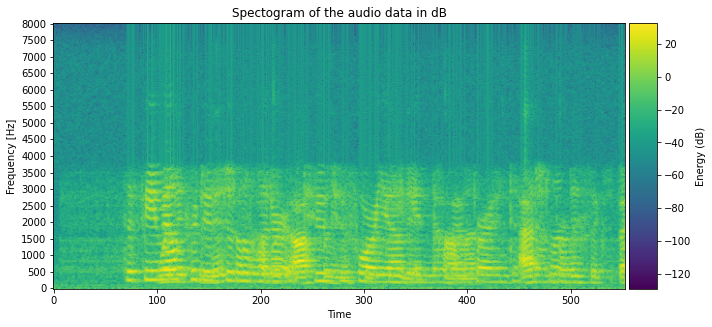

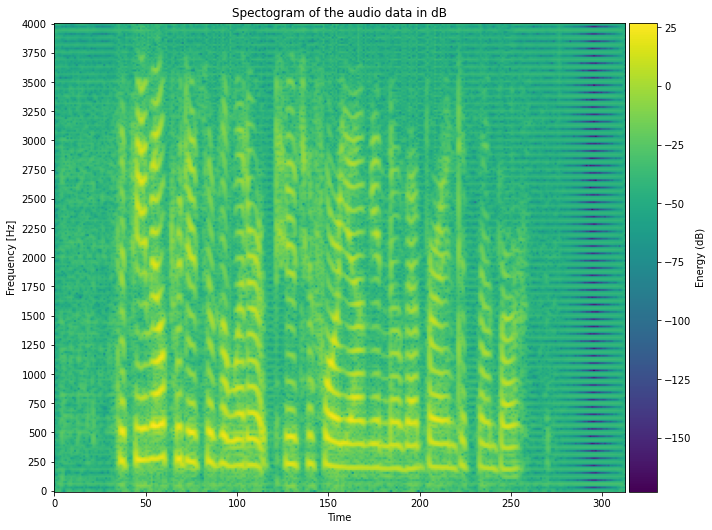

In [6]:
# Because working with pytorch we can load the audio with torchaudio directly to a torch.Tensor
import torchaudio
#HINT 1
#samples_mix, sr = torchaudio.load(path_to_wav)

#HINT 2

from speaker_extraction.extraction_model.deliver import Extractor
extractor = Extractor()

# Plot the spectrogram of the mixed signal and then the extracted signal, Do you see any difference?

####### YOUR CODE HERE #######

mixed = '/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/mix.wav'
ref = '/home/bari/workspace/spring_winter_school/speaker_extraction_workshop/speaker_extraction/outputs/mono_s1/ref1.wav'
mix_vec,sr_mix = torchaudio.load(mixed)
ref_vec,sr_ref = torchaudio.load(ref)

y_hat = extractor.extract_vec(mix_vec,sr_mix,ref_vec,sr_ref)
plot_spectrogram(mix_vec,sr_mix)
display_audio(mix_vec,sr_mix)
plot_spectrogram(y_hat,sr=8000)
display_audio(y_hat,8000)




## 5. Evaluation and Discussion (10 minutes)
The Si-SDR (Scale invariant signal-to-distortion ratio) is a widely used metric in the field of audio signal processing, particularly in the context of source separation. 
$$
\text{Si-SDR} = 10 \log_{10} \left( \frac{{\| \frac{<\hat{s},s>}{<s,s>}\ s\|^2}}{{\| \frac{<\hat{s},s>}{<s,s>}\ s -\hat{s} \|^2}} \right)

$$
The Si-SDR is used measure the quality of separation between the original signal and the extracted signal with adaptation to the gain that the model might add to the extracted signal. 



In [7]:
from torchmetrics.audio import SignalDistortionRatio
from speaker_extraction.extraction_model.deliver import Extractor
import torchaudio.functional as F

extractor = Extractor()
si_sdr = SignalDistortionRatio()
def prepare_batch(wav1_path,wav2_path,ref1_path,ref2_path,input_sr =16000):
    #returns mixed signal, ref1, ref2, org wav1 resampled to 8000, org wav2 resampled to 8000
    wav1,sr_wav1 = torchaudio.load(wav1_path)
    wav2,sr_wav2 = torchaudio.load(wav2_path)
    ref1,sr_ref1 = torchaudio.load(ref1_path)
    ref2,sr_ref2 = torchaudio.load(ref2_path)
    if (sr_ref1 + sr_ref2 +sr_wav1+sr_wav2)/4 != input_sr:
        raise(Exception('input sr does not match'))
    total_len = max(wav1.shape[-1],wav2.shape[-1])
    mixed = mix(wav1,wav2)
    wav1_res = F.resample(wav1,sr_wav1,8000)
    wav2_res = F.resample(wav2,sr_wav2,8000)
    mixed_res = F.resample(mixed,input_sr,8000)
    return mixed,mixed_res,ref1,ref2,wav1_res,wav2_res

wav1_path='audio_samples/males/28233/5105-28233-0006.wav'
wav2_path='audio_samples/females/29095/4970-29095-0034.wav'
ref1_path='audio_samples/males/28233/5105-28233-0008.wav'
ref2_path='audio_samples/females/29095/4970-29095-0038.wav'
input_sr=16000
mixed,mixed_resampled,ref1,ref2,y_1,y_2 = prepare_batch(wav1_path,wav2_path,ref1_path,ref2_path,input_sr)
sf.write('mixed_f1_m1.wav',mixed,sr)
print(transcribe_wav('mixed_f1_m1.wav'))
display_audio(mixed,sr)
y_hat = extractor.extract_vec(mix =mixed.unsqueeze(0),sr_mix=16000,ref=ref1,sr_ref=16000)
display_audio(y_hat,8000)
sf.write('y_hat_f1_m1.wav',y_hat,8000)
print(transcribe_wav('y_hat_f1_m1.wav'))


No should not even be ghost itself and sick 5 was a church has eye the girl.


No cathedral, not even Burg itself, could buy with the church at Mont March.


In [22]:
# plot_spectrogram(y_hat[:y_1.shape[-1]],8000)
input_sisdr =si_sdr(y_hat.squeeze()[:mixed_resampled.shape[-1]],mixed_resampled)
print(input_sisdr)
si= si_sdr(y_hat[:y_1.shape[-1]],y_1.squeeze())
print(si)

def si_sdri(y,y_hat,mixed):
    y = y.squeeze()
    y_hat = y_hat.squeeze()
    mixed=  mixed.squeeze()
    max_len = max(y.shape[0],y_hat.shape[0],mixed.shape[0])
    print(max_len)

si_sdri(y_1,y_hat,mixed_resampled)


tensor(-0.6644)
tensor(5.7068)
79872


## 6. Conclusion (10 minutes)
## Anyone is keen to share his/hers results?

- Summarize key takeaways from the workshop, emphasizing their relevance to the SPRING
project and its goals.
- Provide additional resources for further learning. (papers, sharon's website)